In [2]:
# Copyright (c) Meta Platforms, Inc. and affiliates. All rights reserved.

# Fit a simple Neural Radiance Field via raymarching

This tutorial shows how to fit Neural Radiance Field given a set of views of a scene using differentiable implicit function rendering.

More specifically, this tutorial will explain how to:
1. Create a differentiable implicit function renderer with either image-grid or Monte Carlo ray sampling.
2. Create an Implicit model of a scene.
3. Fit the implicit function (Neural Radiance Field) based on input images using the differentiable implicit renderer. 
4. Visualize the learnt implicit function.

Note that the presented implicit model is a simplified version of NeRF:<br>
_Ben Mildenhall, Pratul P. Srinivasan, Matthew Tancik, Jonathan T. Barron, Ravi Ramamoorthi, Ren Ng: NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis, ECCV 2020._

The simplifications include:
* *Ray sampling*: This notebook does not perform stratified ray sampling but rather ray sampling at equidistant depths.
* *Rendering*: We do a single rendering pass, as opposed to the original implementation that does a coarse and fine rendering pass.
* *Architecture*: Our network is shallower which allows for faster optimization possibly at the cost of surface details.
* *Mask loss*: Since our observations include segmentation masks, we also optimize a silhouette loss that forces rays to either get fully absorbed inside the volume, or to completely pass through it.


## 0. Install and Import modules
Ensure `torch` and `torchvision` are installed. If `pytorch3d` is not installed, install it using the following cell:

In [3]:
import os
import sys
import torch
import mlflow
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.12.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [4]:
# %matplotlib inline
# %matplotlib notebook
import os
import sys
import time
import json
import glob
import torch
import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from IPython import display
from tqdm.notebook import tqdm

# Data structures and functions for rendering
from pytorch3d.structures import Volumes
from pytorch3d.transforms import so3_exp_map
from pytorch3d.renderer import (
    FoVPerspectiveCameras, 
    NDCMultinomialRaysampler,
    MonteCarloRaysampler,
    EmissionAbsorptionRaymarcher,
    ImplicitRenderer,
    RayBundle,
    ray_bundle_to_ray_points,
)
# obtain the utilized device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    print(
        'Please note that NeRF is a resource-demanding method.'
        + ' Running this notebook on CPU will be extremely slow.'
        + ' We recommend running the example on a GPU'
        + ' with at least 10 GB of memory.'
    )
    device = torch.device("cpu")

In [5]:
# !wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
# !wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/generate_cow_renders.py
from src.plot_image_grid import image_grid

OR if running locally uncomment and run the following cell:

## 2. Hyperparams

In [6]:
def split(tensor, tsize):
    return tensor[:-tsize], tensor[-tsize:]

def split_cameras(target_cameras, tsize):
    batch_idx = np.arange(len(cameras) - tsize)
    trn =  FoVPerspectiveCameras(
        R = target_cameras.R[batch_idx], 
        T = target_cameras.T[batch_idx], 
        znear = target_cameras.znear[batch_idx],
        zfar = target_cameras.zfar[batch_idx],
        aspect_ratio = target_cameras.aspect_ratio[batch_idx],
        fov = target_cameras.fov[batch_idx])
    batch_idx = np.arange(len(cameras) - tsize, len(cameras))
    val = FoVPerspectiveCameras(
        R = target_cameras.R[batch_idx], 
        T = target_cameras.T[batch_idx], 
        znear = target_cameras.znear[batch_idx],
        zfar = target_cameras.zfar[batch_idx],
        aspect_ratio = target_cameras.aspect_ratio[batch_idx],
        fov = target_cameras.fov[batch_idx])
    return trn, val
    
if args['dataset'] == 'cow':
    from src.generate_cow_renders import generate_cow_renders
    cameras, images, silhouettes = generate_cow_renders(num_views=args['train_size'] + args['val_size'], azimuth_range=180)
    files = []
    print(f'Generated {len(images)} images/silhouettes/cameras from cows dataset.')
elif args['dataset'] == 'bottles':
    from src.get_bottles import get_cam_img
    files, cameras, images, silhouettes = get_cam_img(train_not_test = True, num_files = args['train_size'] + args['val_size'], resize_ratio = args['resize_ratio'])
    if blackify:
        images = torch.where((images == 1).prod(-1)[...,np.newaxis] == 1, torch.zeros(3), images)
    print(f'Generated {len(images)} images/silhouettes/cameras from bottles. with shape: {images[0].shape}')
else:
    raise ValueError
    
train_files, val_files = split(files, args['val_size'])
train_images, val_images = split(images, args['val_size'])
train_silhouettes, val_silhouettes = split(silhouettes, args['val_size'])
train_cameras, val_cameras = split_cameras(cameras, args['val_size'])

    
    

Generated 55 images/silhouettes/cameras from bottles. with shape: torch.Size([100, 100, 3])


## 2. Initialize the implicit renderer

The following initializes an implicit renderer that emits a ray from each pixel of a target image and samples a set of uniformly-spaced points along the ray. At each ray-point, the corresponding density and color value is obtained by querying the corresponding location in the neural model of the scene (the model is described & instantiated in a later cell).

The renderer is composed of a *raymarcher* and a *raysampler*.
- The *raysampler* is responsible for emitting rays from image pixels and sampling the points along them. Here, we use two different raysamplers:
    - `MonteCarloRaysampler` is used to generate rays from a random subset of pixels of the image plane. The random subsampling of pixels is carried out during **training** to decrease the memory consumption of the implicit model.
    - `NDCMultinomialRaysampler` which follows the standard PyTorch3D coordinate grid convention (+X from right to left; +Y from bottom to top; +Z away from the user). In combination with the implicit model of the scene, `NDCMultinomialRaysampler` consumes a large amount of memory and, hence, is only used for visualizing the results of the training at **test** time.
- The *raymarcher* takes the densities and colors sampled along each ray and renders each ray into a color and an opacity value of the ray's source pixel. Here we use the `EmissionAbsorptionRaymarcher` which implements the standard Emission-Absorption raymarching algorithm.

In [7]:
# 1) Instantiate the raysamplers.

# Here, NDCMultinomialRaysampler generates a rectangular grid for full size image rendering but consequently uses more memory!
# Render size used by NDCRay sampler
render_size = int(images.shape[1] * render_size_factor)
raysampler_grid = NDCMultinomialRaysampler(
    image_height=render_size,
    image_width=render_size,
    n_pts_per_ray=args['n_pts_per_ray'],
    min_depth=args['volume_extent_min'],
    max_depth=args['volume_extent_world'],
)

# MonteCarloRaysampler generates a random subset 
# of `n_rays_per_image` rays emitted from the image plane.
train_raysampler_mc = MonteCarloRaysampler(
    min_x = -1.0,
    max_x = 1.0,
    min_y = -1.0,
    max_y = 1.0,
    n_rays_per_image=args['train_n_rays_per_image'],
    n_pts_per_ray=args['n_pts_per_ray'],
    min_depth=args['volume_extent_min'],
    max_depth=args['volume_extent_world'],
    stratified_sampling = args['stratified_sampling'],
)
# MonteCarloRaysampler generates a random subset 
# of `n_rays_per_image` rays emitted from the image plane.
val_raysampler_mc = MonteCarloRaysampler(
    min_x = -1.0,
    max_x = 1.0,
    min_y = -1.0,
    max_y = 1.0,
    n_rays_per_image=args['val_n_rays_per_image'],
    n_pts_per_ray=args['n_pts_per_ray'],
    min_depth=args['volume_extent_min'],
    max_depth=args['volume_extent_world'],
    stratified_sampling = args['stratified_sampling'],
)

# 2) Instantiate the raymarcher.
# Here, we use the standard EmissionAbsorptionRaymarcher 
# which marches along each ray in order to render
# the ray into a single 3D color vector 
# and an opacity scalar.
raymarcher = EmissionAbsorptionRaymarcher()

# Finally, instantiate the implicit renders
# for both raysamplers.
renderer_grid = ImplicitRenderer(
    raysampler=raysampler_grid, raymarcher=raymarcher,
)
train_renderer_mc = ImplicitRenderer(
    raysampler=train_raysampler_mc, raymarcher=raymarcher,
)
val_renderer_mc = ImplicitRenderer(
    raysampler=val_raysampler_mc, raymarcher=raymarcher,
)

## 4. Helper functions

In this function we define functions that help with the Neural Radiance Field optimization.

In [8]:
def huber(x, y, scaling=0.1):
    """
    A helper function for evaluating the smooth L1 (huber) loss
    between the rendered silhouettes and colors.
    """
    diff_sq = (x - y) ** 2
    loss = ((1 + diff_sq / (scaling**2)).clamp(1e-4).sqrt() - 1) * float(scaling)
    return loss

img2mse = lambda x, y : torch.mean((x - y) ** 2)
mse2psnr = lambda x : -10. * torch.log(x) / torch.log(torch.Tensor([10.]))

def sample_images_at_mc_locs(target_images, sampled_rays_xy):
    """
    Given a set of Monte Carlo pixel locations `sampled_rays_xy`,
    this method samples the tensor `target_images` at the
    respective 2D locations.
    
    This function is used in order to extract the colors from
    ground truth images that correspond to the colors
    rendered using `MonteCarloRaysampler`.
    """
    ba = target_images.shape[0]
    dim = target_images.shape[-1]
    spatial_size = sampled_rays_xy.shape[1:-1]
    # In order to sample target_images, we utilize
    # the grid_sample function which implements a
    # bilinear image sampler.
    # Note that we have to invert the sign of the 
    # sampled ray positions to convert the NDC xy locations
    # of the MonteCarloRaysampler to the coordinate
    # convention of grid_sample.
    images_sampled = torch.nn.functional.grid_sample(
        target_images.permute(0, 3, 1, 2), 
        -sampled_rays_xy.view(ba, -1, 1, 2),  # note the sign inversion
        align_corners=True
    )
    return images_sampled.permute(0, 2, 3, 1).view(
        ba, *spatial_size, dim
    )

def show_full_render(
    neural_radiance_field, camera,
    target_image, target_silhouette,
    tcolor, tpsnr, vcolor, vpsnr,
):
    """
    This is a helper function for visualizing the
    intermediate results of the learning. 
    
    Since the `NeuralRadianceField` suffers from
    a large memory footprint, which does not let us
    render the full image grid in a single forward pass,
    we utilize the `NeuralRadianceField.batched_forward`
    function in combination with disabling the gradient caching.
    This chunks the set of emitted rays to batches and 
    evaluates the implicit function on one batch at a time
    to prevent GPU memory overflow.
    """
    
    # Prevent gradient caching.
    with torch.no_grad():
        # Render using the grid renderer and the
        # batched_forward function of neural_radiance_field.
        rendered_image_silhouette, _ = renderer_grid(
            cameras=camera, 
            volumetric_function=neural_radiance_field.batched_forward
        )
        # Split the rendering result to a silhouette render
        # and the image render.
        rendered_image, rendered_silhouette = (
            rendered_image_silhouette[0].split([3, 1], dim=-1)
        )

    color_err = img2mse(rendered_image, target_image)
    
    loss = color_err
    psnr = mse2psnr(color_err.to('cpu'))
        
    # Generate plots.
    fig, ax = plt.subplots(2, 4, figsize=(15, 10))
    ax = ax.ravel()
    clamp_and_detach = lambda x: x.clamp(0.0, 1.0).cpu().detach().numpy()
    ax[0].plot(np.arange(len(tcolor)), tcolor, linewidth=1)
    ax[1].plot(np.arange(len(vcolor))*val_freq, vcolor, linewidth=1)
    ax[2].imshow(clamp_and_detach(rendered_image))
    ax[3].imshow(clamp_and_detach(rendered_silhouette[..., 0]))
    ax[4].plot(np.arange(len(tpsnr)), tpsnr, linewidth=1)
    ax[5].plot(np.arange(len(vpsnr))*val_freq, vpsnr, linewidth=1)
    ax[6].imshow(clamp_and_detach(target_image))
    ax[7].imshow(clamp_and_detach(target_silhouette))
    for ax_, title_ in zip(
        ax,
        (
            "loss train color", "loss val color", "rendered image", "rendered silhouette",
            "loss train psnr", "loss val psnr","target val image",  "target val silhouette",
        )
    ):
        if not title_.startswith('loss'):
            ax_.grid("off")
            ax_.axis("off")
        ax_.set_title(title_)
    fig.canvas.draw(); fig.show()
    display.clear_output(wait=True)
    display.display(fig)
    return fig, loss, psnr


## 5. Fit the radiance field

Here we carry out the radiance field fitting with differentiable rendering.

In order to fit the radiance field, we render it from the viewpoints of the `target_cameras`
and compare the resulting renders with the observed `target_images` and `target_silhouettes`.

The comparison is done by evaluating the mean huber (smooth-l1) error between corresponding
pairs of `target_images`/`rendered_images` and `target_silhouettes`/`rendered_silhouettes`.

Since we use the `MonteCarloRaysampler`, the outputs of the training renderer `renderer_mc`
are colors of pixels that are randomly sampled from the image plane, not a lattice of pixels forming
a valid image. Thus, in order to compare the rendered colors with the ground truth, we 
utilize the random MonteCarlo pixel locations to sample the ground truth images/silhouettes
`target_silhouettes`/`rendered_silhouettes` at the xy locations corresponding to the render
locations. This is done with the helper function `sample_images_at_mc_locs`, which is
described in the previous cell.

In [9]:
def visualize_full_size(nerf, device, target_cameras, target_images, target_silhouettes, *histories):
    show_idx = torch.randperm(len(target_cameras))[:1]
    return show_full_render(
            nerf.to(device),
            FoVPerspectiveCameras(
                R = target_cameras.R[show_idx], 
                T = target_cameras.T[show_idx], 
                znear = target_cameras.znear[show_idx],
                zfar = target_cameras.zfar[show_idx],
                aspect_ratio = target_cameras.aspect_ratio[show_idx],
                fov = target_cameras.fov[show_idx],
                device = device,
            ), 
            target_images[show_idx][0],
            target_silhouettes[show_idx][0],
            *histories
        )
        
def log_stuff(loss, psnr, hist_col, hist_psnr, prefix):
    # Log the loss history.
    hist_col.append(float(loss))
    hist_psnr.append(float(psnr))
    if log_mlflow:
        mlflow.log_metrics({prefix + ' loss color': loss, prefix + ' psnr': psnr})

def run_loop(renderer_mc, target_cameras, target_images, device, neural_radiance_field):
    batch_size = len(target_cameras) // args['accum_iter']
    
    # Sample random batch indices.
    batch_idx = torch.randperm(len(target_cameras))[:batch_size]
    # Sample the minibatch of cameras.
    batch_cameras = FoVPerspectiveCameras(
        R = target_cameras.R[batch_idx], 
        T = target_cameras.T[batch_idx], 
        znear = target_cameras.znear[batch_idx],
        zfar = target_cameras.zfar[batch_idx],
        aspect_ratio = target_cameras.aspect_ratio[batch_idx],
        fov = target_cameras.fov[batch_idx],
        device = device,
    )
    
    # Evaluate the nerf model.
    rendered_images_silhouettes, sampled_rays = renderer_mc(
        cameras=batch_cameras, 
        volumetric_function=neural_radiance_field
    )
    rendered_images, rendered_silhouettes = (
        rendered_images_silhouettes.split([3, 1], dim=-1)
    )
    
    # Loss
    colors_at_rays = sample_images_at_mc_locs(
        target_images[batch_idx], 
        sampled_rays.xys
    )
    color_err = img2mse(rendered_images, colors_at_rays)
    
    loss = color_err
    psnr = mse2psnr(color_err.to('cpu'))
    return loss, psnr

In [ ]:
from src.Network import NeuralRadianceField_Heavy

# First move all relevant variables to the correct device.
renderer_grid = renderer_grid.to(device)
train_renderer_mc = train_renderer_mc.to(device)
val_renderer_mc = val_renderer_mc.to(device)
train_images = train_images.to(device)
val_images = val_images.to(device)

# Set the seed for reproducibility
torch.manual_seed(1)

# Instantiate the radiance field model.
neural_radiance_field = NeuralRadianceField_Heavy(D = args['num_layers'],
                                            skips = args['skips'],
                                            n_harmonic_functions_pos = args['n_harmonic_functions_pos'],
                                           n_harmonic_functions_dir = args['n_harmonic_functions_dir']).to(device)
# Optimizer
lr = args['learning_rate']
optimizer = torch.optim.Adam(neural_radiance_field.parameters(), lr=lr)
optimizer.zero_grad(set_to_none=True)

# Init the loss history buffers.
train_loss_history_color, train_psnr_history = [], []
val_loss_history_color, val_psnr_history = [], []

for iteration in range(args['num_iterations']):      
    
    # Exponential decay
    if iteration <= round(0.75*args['num_iterations']):
        new_lrate = lr * (0.1 ** (iteration / round(0.75*args['iteration_for_lr_decay'])))
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lrate
            
    # run train loop and log values
    loss, psnr = run_loop(train_renderer_mc, train_cameras, train_images, device, neural_radiance_field)
    log_stuff(loss, psnr, train_loss_history_color, train_psnr_history, 'train')
    
    # Take the optimization step, but scale the loss appropriately firs
    loss /= args['accum_iter']
    loss.backward()
    
    # weights update with gradient accumulation
    if ((iteration + 1) % args['accum_iter'] == 0) or (iteration + 1 == args['num_iterations']):
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        
    if iteration % val_freq == 0:
        # run val loop and log values
        loss, psnr = run_loop(val_renderer_mc, val_cameras, val_images, device, neural_radiance_field)
        log_stuff(loss, psnr, val_loss_history_color, val_psnr_history, 'val')
        print(f'======>Validation Iteration {iteration:05d}: loss color = {float(loss):1.2e} psnr = {float(psnr):1.2e}')

    # Every 20 iterations, print the current values of the losses, and save model
    if iteration % 20 == 0:
        print(f'Iteration {iteration:05d}: loss color = {float(loss):1.2e} psnr = {float(psnr):1.2e}')
        if iteration % (100*args['accum_iter']) == 0:
            torch.save({
                'epoch': iteration,
                'train_files': train_files,
                'model_state_dict': neural_radiance_field.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss_history_color': train_loss_history_color,
                'train_psnr_history': train_psnr_history,
                'val_loss_history_color': val_loss_history_color,
                'val_psnr_history': val_psnr_history,
                }, model_save_path)
    
    # Visualize the full renders
    if iteration % viz_freq == 0:
        if viz_train:
            params = [train_cameras, train_images, train_silhouettes]
        else:
            params = [val_cameras, val_images, val_silhouettes]
        fig, loss, psnr = visualize_full_size(neural_radiance_field, device, *params, 
                           train_loss_history_color, train_psnr_history, val_loss_history_color, val_psnr_history)
        print(f'#####>Full size validation Iteration {iteration:05d}: loss color = {float(loss):1.2e} psnr = {float(psnr):1.2e}')
        #fig 

In [1]:
# Our rendered scene is centered around (0,0,0) 
# and is enclosed inside a bounding box
# whose side is roughly equal to 3.0 (world units).
args = {}
args['volume_extent_world'] = 5.0
args['volume_extent_min'] = 0.1
render_size_factor = 1

viz_freq = 100
viz_train = False
val_freq = 100

args['dataset'] = 'bottles' #[bottles, cow]
args['resize_ratio'] = 100/800
args['train_size'] = 50
args['val_size'] = 5
blackify = True

args['learning_rate'] = 5e-4
args['iteration_for_lr_decay'] = 100000
args['num_iterations'] = 30000
args['accum_iter'] = 1
# args['num_iterations'] after counting gradient accumulation
args['num_iterations'] *= args['accum_iter']

args['train_n_rays_per_image'] = 4096 // args['train_size']
args['val_n_rays_per_image'] = 4096 // args['val_size']
args['n_pts_per_ray'] = 128
args['stratified_sampling'] = True

args['num_layers'] = 4
skip_attach_after = 3
args['skips']=[skip_attach_after-1] if skip_attach_after is not None else []

model_save_path = f"models/{args['dataset']}_{args['num_iterations']}_{args['resize_ratio']}_{args['train_size']}_{args['num_layers']}_{args['accum_iter']}.tar"
args['n_harmonic_functions_pos'] = 10
args['n_harmonic_functions_dir'] = 4
n_harmonic_functions = 10

log_mlflow = False
if log_mlflow:
    mlflow.set_experiment('Lower size')
    mlflow.start_run('Base')

    mlflow.log_params(args)

Iteration 26540: loss color = 1.91e-02 psnr = 1.72e+01
Iteration 26560: loss color = 2.45e-02 psnr = 1.61e+01
Iteration 26580: loss color = 1.77e-02 psnr = 1.75e+01
Iteration 26600: loss color = 2.25e-02 psnr = 1.65e+01
Iteration 26620: loss color = 1.47e-02 psnr = 1.83e+01
Iteration 26640: loss color = 1.84e-02 psnr = 1.74e+01
Iteration 26660: loss color = 2.12e-02 psnr = 1.67e+01
Iteration 26680: loss color = 2.36e-02 psnr = 1.63e+01
Iteration 26700: loss color = 2.31e-02 psnr = 1.64e+01
Iteration 26720: loss color = 2.15e-02 psnr = 1.67e+01
Iteration 26740: loss color = 2.43e-02 psnr = 1.61e+01
Iteration 26760: loss color = 1.60e-02 psnr = 1.79e+01
Iteration 26780: loss color = 1.74e-02 psnr = 1.76e+01
Iteration 26800: loss color = 1.95e-02 psnr = 1.71e+01
Iteration 26820: loss color = 1.52e-02 psnr = 1.82e+01
Iteration 26840: loss color = 1.87e-02 psnr = 1.73e+01
Iteration 26860: loss color = 1.89e-02 psnr = 1.72e+01
Iteration 26880: loss color = 1.64e-02 psnr = 1.79e+01
Iteration 26900: loss color = 1.52e-02 psnr = 1.82e+01
Iteration 26920: loss color = 2.18e-02 psnr = 1.66e+01
Iteration 26940: loss color = 2.11e-02 psnr = 1.67e+01
Iteration 26960: loss color = 1.64e-02 psnr = 1.79e+01
Iteration 26980: loss color = 1.95e-02 psnr = 1.71e+01

## 6. Visualizing the optimized neural radiance field

Finally, we visualize the neural radiance field by rendering from multiple viewpoints that rotate around the volume's y-axis.

Rendering rotating NeRF ...


  0%|          | 0/15 [00:00<?, ?it/s]

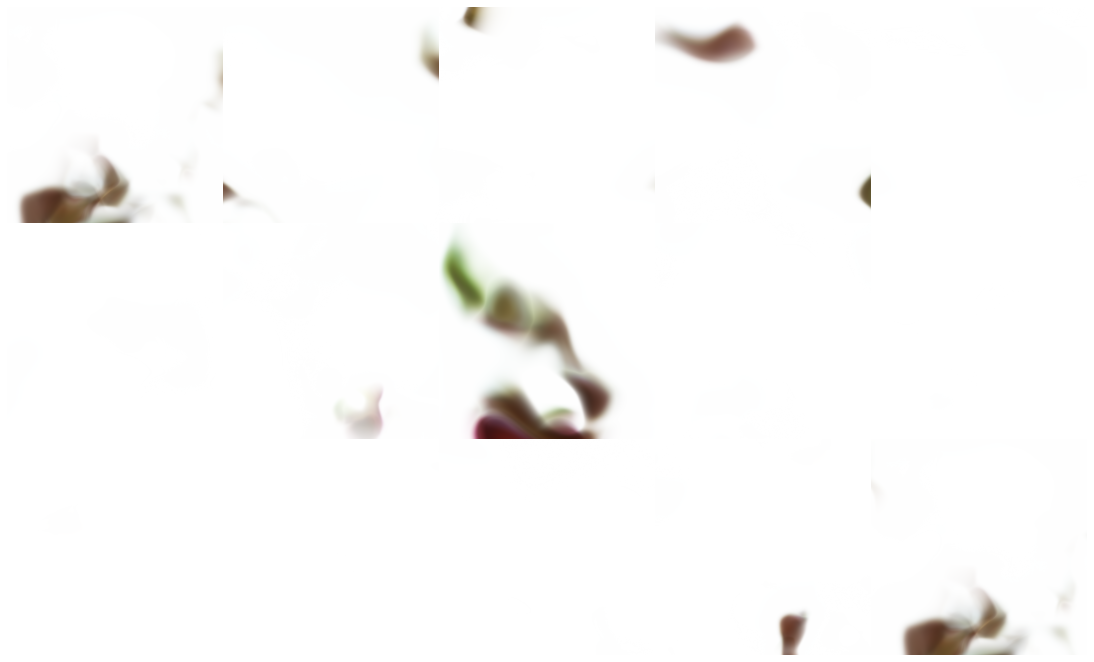

In [12]:
def generate_rotating_nerf(neural_radiance_field, n_frames = 50):
    logRs = torch.zeros(n_frames, 3, device=device)
    logRs[:, 1] = torch.linspace(-3.14, 3.14, n_frames, device=device)
    Rs = so3_exp_map(logRs)
    Ts = torch.zeros(n_frames, 3, device=device)
    Ts[:, 2] = 2.7
    frames = []
    print('Rendering rotating NeRF ...')
    for R, T in zip(tqdm(Rs), Ts):
        camera = FoVPerspectiveCameras(
            R=R[None], 
            T=T[None], 
            znear=target_cameras.znear[0],
            zfar=target_cameras.zfar[0],
            aspect_ratio=target_cameras.aspect_ratio[0],
            fov=target_cameras.fov[0],
            device=device,
        )
        # Note that we again render with `NDCMultinomialRaysampler`
        # and the batched_forward function of neural_radiance_field.
        frames.append(
            renderer_grid(
                cameras=camera, 
                volumetric_function=neural_radiance_field.batched_forward,
            )[0][..., :3]
        )
    return torch.cat(frames)
    
with torch.no_grad():
    rotating_nerf_frames = generate_rotating_nerf(neural_radiance_field, n_frames=3*5)
    
image_grid(rotating_nerf_frames.clamp(0., 1.).cpu().numpy(), rows=3, cols=5, rgb=True, fill=True)
plt.savefig(model_save_path.replace('.tar', '.png'))
plt.show()

## 7. Conclusion

In this tutorial, we have shown how to optimize an implicit representation of a scene such that the renders of the scene from known viewpoints match the observed images for each viewpoint. The rendering was carried out using the PyTorch3D's implicit function renderer composed of either a `MonteCarloRaysampler` or `NDCMultinomialRaysampler`, and an `EmissionAbsorptionRaymarcher`.